# Imports

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import ta

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
from pprint import pprint

import gc
import optuna
from sklearn.feature_selection import RFE


/tmp/ipykernel_5249/384002432.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [23]:
df = pd.read_csv('Data/Training/pair_features1_300_120.csv')
df.head()

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,same_sector_flag,same_sub_industry_flag,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls
0,WELL,2001-02-08 00:00:00,18.850,18.710,61000.000,5.181,JBHT,4.797,4.656,348400.000,3.771,False,False,1.410,1.297,0.508,1.229,0.342,0.155
1,WELL,2001-02-09 00:00:00,18.900,18.620,78500.000,5.128,JBHT,4.781,4.656,1077600.000,3.859,False,False,1.269,1.298,0.508,1.217,0.330,0.088
2,WELL,2001-02-12 00:00:00,18.910,18.640,76700.000,5.142,JBHT,4.766,4.516,561600.000,3.859,False,False,1.283,1.299,0.507,1.204,0.314,0.056
3,WELL,2001-02-13 00:00:00,18.980,18.650,58600.000,5.197,JBHT,4.812,4.723,1248400.000,3.869,False,False,1.328,1.301,0.506,1.194,0.300,0.033
4,WELL,2001-02-14 00:00:00,19.000,18.870,75600.000,5.222,JBHT,4.812,4.656,446400.000,3.783,False,False,1.439,1.302,0.506,1.186,0.289,0.044


In [24]:
df['pnls'] = df['pnls']*100.0

In [25]:
total_days = df.Date.nunique()
total_days

5259

In [26]:
df.dropna()

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,same_sector_flag,same_sub_industry_flag,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls
0,WELL,2001-02-08 00:00:00,18.850,18.710,61000.000,5.181,JBHT,4.797,4.656,348400.000,3.771,False,False,1.410,1.297,0.508,1.229,0.342,15.520
1,WELL,2001-02-09 00:00:00,18.900,18.620,78500.000,5.128,JBHT,4.781,4.656,1077600.000,3.859,False,False,1.269,1.298,0.508,1.217,0.330,8.831
2,WELL,2001-02-12 00:00:00,18.910,18.640,76700.000,5.142,JBHT,4.766,4.516,561600.000,3.859,False,False,1.283,1.299,0.507,1.204,0.314,5.556
3,WELL,2001-02-13 00:00:00,18.980,18.650,58600.000,5.197,JBHT,4.812,4.723,1248400.000,3.869,False,False,1.328,1.301,0.506,1.194,0.300,3.256
4,WELL,2001-02-14 00:00:00,19.000,18.870,75600.000,5.222,JBHT,4.812,4.656,446400.000,3.783,False,False,1.439,1.302,0.506,1.186,0.289,4.442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254,WELL,2021-12-28 00:00:00,84.850,83.610,1224800.000,79.186,JBHT,204.380,202.080,260300.000,199.753,False,False,120.567,90.672,13.758,114.376,3.096,4.383
5255,WELL,2021-12-29 00:00:00,85.330,83.340,1219600.000,79.541,JBHT,206.840,203.150,243000.000,201.674,False,False,122.133,90.842,13.830,114.666,3.132,2.975
5256,WELL,2021-12-30 00:00:00,86.350,84.930,1380000.000,80.279,JBHT,205.790,203.280,203900.000,199.694,False,False,119.414,90.996,13.891,114.870,3.101,2.975
5257,WELL,2021-12-31 00:00:00,86.690,85.580,1301100.000,80.158,JBHT,205.470,201.490,239800.000,200.351,False,False,120.193,91.148,13.959,115.026,3.169,2.975


In [27]:
df = df.sort_values('Date')

In [29]:
print(df.Date.min(),df.Date.max())
df

2001-02-08 00:00:00 2022-01-03 00:00:00


,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,same_sector_flag,same_sub_industry_flag,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls
0,WELL,2001-02-08 00:00:00,18.850,18.710,61000.000,5.181,JBHT,4.797,4.656,348400.000,3.771,False,False,1.410,1.297,0.508,1.229,0.342,15.520
1,WELL,2001-02-09 00:00:00,18.900,18.620,78500.000,5.128,JBHT,4.781,4.656,1077600.000,3.859,False,False,1.269,1.298,0.508,1.217,0.330,8.831
2,WELL,2001-02-12 00:00:00,18.910,18.640,76700.000,5.142,JBHT,4.766,4.516,561600.000,3.859,False,False,1.283,1.299,0.507,1.204,0.314,5.556
3,WELL,2001-02-13 00:00:00,18.980,18.650,58600.000,5.197,JBHT,4.812,4.723,1248400.000,3.869,False,False,1.328,1.301,0.506,1.194,0.300,3.256
4,WELL,2001-02-14 00:00:00,19.000,18.870,75600.000,5.222,JBHT,4.812,4.656,446400.000,3.783,False,False,1.439,1.302,0.506,1.186,0.289,4.442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254,WELL,2021-12-28 00:00:00,84.850,83.610,1224800.000,79.186,JBHT,204.380,202.080,260300.000,199.753,False,False,120.567,90.672,13.758,114.376,3.096,4.383
5255,WELL,2021-12-29 00:00:00,85.330,83.340,1219600.000,79.541,JBHT,206.840,203.150,243000.000,201.674,False,False,122.133,90.842,13.830,114.666,3.132,2.975
5256,WELL,2021-12-30 00:00:00,86.350,84.930,1380000.000,80.279,JBHT,205.790,203.280,203900.000,199.694,False,False,119.414,90.996,13.891,114.870,3.101,2.975
5257,WELL,2021-12-31 00:00:00,86.690,85.580,1301100.000,80.158,JBHT,205.470,201.490,239800.000,200.351,False,False,120.193,91.148,13.959,115.026,3.169,2.975


## Technical Indicators

In [9]:
class feature_engineering(object):
    def __init__(self):
        super(feature_engineering, self).__init__()

    def generate_technical_indicator(self, data_df): 
        '''
        Function to generate additional technical indicators for the stock

        Uses the "statsmodels.tsa.stattools" (as "ts") package to apply 
        the equations specified in the "Technical Indicators" markdown section 
        to stock closing data.
        
        Input:
        data_df-- Dataframe containing stock finacials data
        
        Output:
        Stock finacials data with added Dataframe of feature obtained from feature engineering
        ''' 
        # 1. Momentum Indicators
        # Relative Strength Index
        df = data_df
#         df['rsi'] = ta.momentum.rsi(df['Close'], window=14)
#         # Kaufman’s Adaptive Moving Average (KAMA)
#         df['kama'] = ta.momentum.kama(df['Close'],window=14)

#         # 2. Volume Indicators
#         # Accumulation/Distribution Index (ADI)
#         df['adi'] = ta.volume.acc_dist_index(df['High'], df['Low'], df['Close'], df['Volume'])

#         # Volume-price trend (VPT)
#         df['vpt'] = ta.volume.volume_price_trend(df['Close'], df['Volume'])

#         # 3. Volatility Indicators
#         # Average True Range (ATR)
#         df['atr'] = ta.volatility.average_true_range(df['High'], df['Low'],df['Close'], window=14)

#         # Bollinger Bands (BB) N-period simple moving average (MA)
#         df['bb_ma'] = ta.volatility.bollinger_mavg(df['Close'], window=20)

#         # 4. Trend Indicators
#         # Average Directional Movement Index (ADX)
#         df['adx'] = ta.trend.adx(df['High'], df['Low'], df['Close'], window=14)

#         # Exponential Moving Average
#         df['ema'] = ta.trend.ema_indicator(df['Close'], window=14)

#         # Moving Average Convergence Divergence (MACD)
#         df['macd'] = ta.trend.macd(df['Close'], window_fast=14, window_slow=30)

#         # 5. Other Indicators
#         # Daily Log Return (DLR)
#         df['dlr'] = ta.others.daily_log_return(df['Close'])

#         # Daily Returns
#         df['daily_returns'] = df['Close'].pct_change()

#         # Moving Averages
#         averages = [50,200]
#         for avg in averages:
#             col_name = str(avg) +' Days Average'
#             df[col_name] = df['Close'].rolling(window = avg, center = False).mean()

        return df

### Load SPY

In [30]:
# spy_df = pd.read_csv('Data/1999-12-01-2023-12-31_SPY.csv')
# spy_df = spy_df[['Date','Adj Close']]
# spy_df.columns = ['Date','SPY_Close']
# df = pd.merge(df,spy_df,on='Date',how='left')

In [31]:
# del spy_df
# gc.collect()

In [32]:
df = df.dropna()
df

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,same_sector_flag,same_sub_industry_flag,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls
0,WELL,2001-02-08 00:00:00,18.850,18.710,61000.000,5.181,JBHT,4.797,4.656,348400.000,3.771,False,False,1.410,1.297,0.508,1.229,0.342,15.520
1,WELL,2001-02-09 00:00:00,18.900,18.620,78500.000,5.128,JBHT,4.781,4.656,1077600.000,3.859,False,False,1.269,1.298,0.508,1.217,0.330,8.831
2,WELL,2001-02-12 00:00:00,18.910,18.640,76700.000,5.142,JBHT,4.766,4.516,561600.000,3.859,False,False,1.283,1.299,0.507,1.204,0.314,5.556
3,WELL,2001-02-13 00:00:00,18.980,18.650,58600.000,5.197,JBHT,4.812,4.723,1248400.000,3.869,False,False,1.328,1.301,0.506,1.194,0.300,3.256
4,WELL,2001-02-14 00:00:00,19.000,18.870,75600.000,5.222,JBHT,4.812,4.656,446400.000,3.783,False,False,1.439,1.302,0.506,1.186,0.289,4.442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254,WELL,2021-12-28 00:00:00,84.850,83.610,1224800.000,79.186,JBHT,204.380,202.080,260300.000,199.753,False,False,120.567,90.672,13.758,114.376,3.096,4.383
5255,WELL,2021-12-29 00:00:00,85.330,83.340,1219600.000,79.541,JBHT,206.840,203.150,243000.000,201.674,False,False,122.133,90.842,13.830,114.666,3.132,2.975
5256,WELL,2021-12-30 00:00:00,86.350,84.930,1380000.000,80.279,JBHT,205.790,203.280,203900.000,199.694,False,False,119.414,90.996,13.891,114.870,3.101,2.975
5257,WELL,2021-12-31 00:00:00,86.690,85.580,1301100.000,80.158,JBHT,205.470,201.490,239800.000,200.351,False,False,120.193,91.148,13.959,115.026,3.169,2.975


### Beta

In [33]:
def compute_beta(rs,df,ticker,market):
    rows = df.loc[rs.index]
    sec_returns = np.log( df[[ticker,market]] / df[[ticker,market]].shift(1) ) 

    cov = sec_returns.cov() * 250
    cov_with_market = cov.iloc[0,1]
    market_var = sec_returns[market].var() * 250
    beta = cov_with_market / market_var
    return beta

In [34]:
all_tickers = df['Ticker_P1'].unique().tolist()+df['Ticker_P2'].unique().tolist()
len(all_tickers)

2

In [35]:
fe_obj = feature_engineering()

### Single Ticker Features

In [36]:
df.columns

Index(['Ticker_P1', 'Date', 'High_P1', 'Low_P1', 'Volume_P1', 'Close_P1',
       'Ticker_P2', 'High_P2', 'Low_P2', 'Volume_P2', 'Close_P2',
       'same_sector_flag', 'same_sub_industry_flag', 'abs_spread',
       'abs_spread_mean', 'abs_spread_std', 'abs_spread_mean_MA',
       'abs_spread_std_MA', 'pnls'],
      dtype='object')

In [37]:
df.sort_values('Date')

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,same_sector_flag,same_sub_industry_flag,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls
0,WELL,2001-02-08 00:00:00,18.850,18.710,61000.000,5.181,JBHT,4.797,4.656,348400.000,3.771,False,False,1.410,1.297,0.508,1.229,0.342,15.520
1,WELL,2001-02-09 00:00:00,18.900,18.620,78500.000,5.128,JBHT,4.781,4.656,1077600.000,3.859,False,False,1.269,1.298,0.508,1.217,0.330,8.831
2,WELL,2001-02-12 00:00:00,18.910,18.640,76700.000,5.142,JBHT,4.766,4.516,561600.000,3.859,False,False,1.283,1.299,0.507,1.204,0.314,5.556
3,WELL,2001-02-13 00:00:00,18.980,18.650,58600.000,5.197,JBHT,4.812,4.723,1248400.000,3.869,False,False,1.328,1.301,0.506,1.194,0.300,3.256
4,WELL,2001-02-14 00:00:00,19.000,18.870,75600.000,5.222,JBHT,4.812,4.656,446400.000,3.783,False,False,1.439,1.302,0.506,1.186,0.289,4.442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254,WELL,2021-12-28 00:00:00,84.850,83.610,1224800.000,79.186,JBHT,204.380,202.080,260300.000,199.753,False,False,120.567,90.672,13.758,114.376,3.096,4.383
5255,WELL,2021-12-29 00:00:00,85.330,83.340,1219600.000,79.541,JBHT,206.840,203.150,243000.000,201.674,False,False,122.133,90.842,13.830,114.666,3.132,2.975
5256,WELL,2021-12-30 00:00:00,86.350,84.930,1380000.000,80.279,JBHT,205.790,203.280,203900.000,199.694,False,False,119.414,90.996,13.891,114.870,3.101,2.975
5257,WELL,2021-12-31 00:00:00,86.690,85.580,1301100.000,80.158,JBHT,205.470,201.490,239800.000,200.351,False,False,120.193,91.148,13.959,115.026,3.169,2.975


In [45]:
df.columns

Index(['Ticker_P1', 'Date', 'High_P1', 'Low_P1', 'Volume_P1', 'Close_P1',
       'Ticker_P2', 'High_P2', 'Low_P2', 'Volume_P2', 'Close_P2',
       'same_sector_flag', 'same_sub_industry_flag', 'abs_spread',
       'abs_spread_mean', 'abs_spread_std', 'abs_spread_mean_MA',
       'abs_spread_std_MA', 'pnls'],
      dtype='object')

In [47]:
X = df[df.columns.drop('pnls')]
y = df['pnls']

X = X.drop(['Date', 'Ticker_P1', 'Ticker_P2'],axis=1)

In [52]:
X

,High_P1,Low_P1,Volume_P1,Close_P1,High_P2,Low_P2,Volume_P2,Close_P2,same_sector_flag,same_sub_industry_flag,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA
0,18.850,18.710,61000.000,5.181,4.797,4.656,348400.000,3.771,False,False,1.410,1.297,0.508,1.229,0.342
1,18.900,18.620,78500.000,5.128,4.781,4.656,1077600.000,3.859,False,False,1.269,1.298,0.508,1.217,0.330
2,18.910,18.640,76700.000,5.142,4.766,4.516,561600.000,3.859,False,False,1.283,1.299,0.507,1.204,0.314
3,18.980,18.650,58600.000,5.197,4.812,4.723,1248400.000,3.869,False,False,1.328,1.301,0.506,1.194,0.300
4,19.000,18.870,75600.000,5.222,4.812,4.656,446400.000,3.783,False,False,1.439,1.302,0.506,1.186,0.289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254,84.850,83.610,1224800.000,79.186,204.380,202.080,260300.000,199.753,False,False,120.567,90.672,13.758,114.376,3.096
5255,85.330,83.340,1219600.000,79.541,206.840,203.150,243000.000,201.674,False,False,122.133,90.842,13.830,114.666,3.132
5256,86.350,84.930,1380000.000,80.279,205.790,203.280,203900.000,199.694,False,False,119.414,90.996,13.891,114.870,3.101
5257,86.690,85.580,1301100.000,80.158,205.470,201.490,239800.000,200.351,False,False,120.193,91.148,13.959,115.026,3.169


## Train test split

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)

In [81]:
print(df.loc[X_val.index].Date.min(),df.loc[X_val.index].Date.max())

2017-10-30 00:00:00 2019-12-02 00:00:00


# Regression

### Filter Outliers?

In [59]:
u = np.mean(y_train)
s = np.std(y_train)
y_train = y_train[(y_train>(u-2*s)) & (y_train<(u+2*s))]
X_train = X_train.loc[y_train.index]

## Linear Regression

In [82]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout
#Creating the LSTM model
class lstm(Model):
    def __init__(self, in_shape, look_back):
        super(lstm, self).__init__()
        self.shape = in_shape
        self.look_back = look_back
        self.lstm_l1 = LSTM(256, input_shape=self.shape, return_sequences = True)
#         self.lstm_l2 = LSTM(256)
        self.dropout = Dropout(0.2)
        self.dense = Dense(self.look_back)

    def call(self, x):
        x = self.lstm_l1(x)
#         x = self.lstm_l2(x)
        x = self.dropout(x)
        x = self.dense(x)
        return x

In [83]:
# Reshape X for model training
trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])).astype(np.float32)
valX = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1])).astype(np.float32)
testX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1])).astype(np.float32)

In [91]:
#initializing the lstm model
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3,\
                                            min_delta=0.0001,restore_best_weights=True,verbose=1)

lstm_model = lstm((trainX.shape[1], trainX.shape[2]), look_back = 1)
lstm_model.compile(loss='mae', 
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), metrics=['mae'])
#fitting the model
history = lstm_model.fit(
                    trainX, 
                    y_train, 
                    epochs=20, 
                    batch_size=32,
                    validation_data=(valX, y_val), 
                    verbose=1, 
                    callbacks=callback,
                    shuffle=True)

Epoch 1/50
132/132 [==============================] - 2s 7ms/step - loss: 3.0562 - mae: 3.0562 - val_loss: 5.0686 - val_mae: 5.0686
Epoch 2/50
132/132 [==============================] - 1s 4ms/step - loss: 2.8385 - mae: 2.8385 - val_loss: 5.0710 - val_mae: 5.0710
Epoch 3/50
132/132 [==============================] - 1s 4ms/step - loss: 2.8236 - mae: 2.8236 - val_loss: 5.0869 - val_mae: 5.0869
Epoch 4/50
132/132 [==============================] - 1s 4ms/step - loss: 2.8215 - mae: 2.8215 - val_loss: 5.0813 - val_mae: 5.0813
Epoch 4: early stopping


In [92]:
lstm_model.summary()

Model: "lstm_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              multiple                  278528    
                                                                 
 dropout_6 (Dropout)         multiple                  0         
                                                                 
 dense_6 (Dense)             multiple                  257       
                                                                 
Total params: 278785 (1.06 MB)
Trainable params: 278785 (1.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


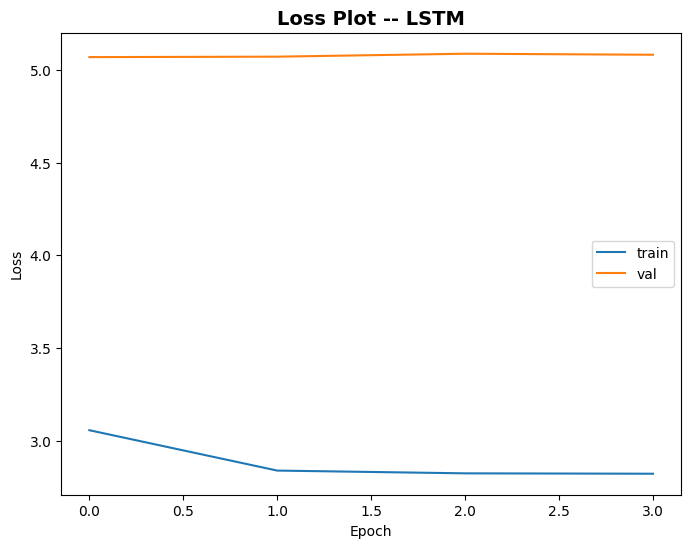

In [93]:
# Plot line graph to show amount loss according the the epoch
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss Plot -- LSTM', fontsize=14, color="black", fontweight="bold")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [94]:
lstm_mae = (lstm_model.predict(testX).flatten() - y_test).abs().mean()
lstm_mae

17/17 [==============================] - 0s 1ms/step


6.320510454529351

In [95]:
lstm_mae / y_test.abs().mean()

0.6896318077008052

In [125]:
# regr = LinearRegression()

# # Train the model using the training sets
# regr.fit(scaled_X_train, y_train)

# # Make predictions using the testing set
# lr_preds = regr.predict(scaled_X_test)

In [126]:
# pi = permutation_importance(regr,scaled_X_test,y_test)

# coefs = pd.DataFrame(
#     pi['importances_mean'], columns=["Coefficients"], index=X_train.drop(categorical_features,axis=1).columns
# )


# coefs.plot(kind="barh", figsize=(9, 7))
# plt.title("LR model")
# plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)

In [127]:
# lr_results = pd.DataFrame({'preds':lr_preds,'true':y_test})
# lr_results

In [128]:
# lr_pnl_is_0 = lr_results[lr_results.true==0]
# lr_pnl_not_0 = lr_results[lr_results.true!=0]

In [129]:
# mae = (lr_pnl_not_0.preds-lr_pnl_not_0.true).abs().mean()

In [130]:
# mae/mean_abs_label

In [131]:
# lr_results.loc[tmp_df.index]

In [132]:
# from sklearn.ensemble import RandomForestRegressor

In [133]:
# rf = RandomForestRegressor(verbose=2,n_jobs=-1)

In [134]:
# rf.fit(X_train.drop(categorical_features,axis=1),y_train)

In [135]:
# preds = rf.predict(X_test.drop(categorical_features,axis=1))

In [136]:
# mae = (preds-y_test).abs().mean()
# mae

In [137]:
# mae/mean_abs_label